In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder,  FunctionTransformer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
import pickle
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from preprocess_data import categorize_bmi_and_interaction

In [12]:
file_path = 'data_cleaned.csv'

df = pd.read_csv(file_path)

X = df.drop('charges', axis=1)
y = df['charges']

# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
# 80% pour train et 20% de test


Recherche des meilleurs hyperparamètres de ElasticNet
Affichage du score, qui est le meilleur résultat

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# # Charger les données
# file_path = 'data_original.csv'
# df = pd.read_csv(file_path)
# df = df.drop_duplicates()

# Fonction pour catégoriser l'IMC et créer une caractéristique d'interaction
def categorize_bmi_and_interaction(df):
    df['bmi_category'] = pd.cut(df['bmi'], 
                                bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                                labels=['underweight', 'normal weight', 'overweight', 'obesity class I', 'obesity class II', 'obesity class III'])
    df['smoker_num'] = df['smoker'].map({'yes': 1, 'no': 0})
    df['bmi_smoker_interaction'] = df['bmi'] * df['smoker_num']
    return df

# Préparer les données
X = df.drop('charges', axis=1)
y = df['charges']


# Fonctions pour construire et entraîner les modèles
# Chaque fonction utilise le pipeline et la grille de recherche pour l'optimisation des hyperparamètres et renvoie le meilleur modèle ainsi que son score

def build_and_train_model(model, X, y, param_grid, model_name):

    # Séparation des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

    pipeline = make_pipeline(
    FunctionTransformer(categorize_bmi_and_interaction),
    ColumnTransformer(
    transformers=[
    ('num', StandardScaler(), ['age', 'children', 'bmi', 'bmi_smoker_interaction']),
    ('cat', OneHotEncoder(), ['sex', 'smoker', 'bmi_category', 'region'])
    ]
    ),
    PolynomialFeatures(2),
    model
    )

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    score = best_model.score(X_test, y_test)

    print(f"Meilleur score pour {model_name}: {score}, avec les paramètres: {grid_search.best_params_}")
    return best_model, score

#Paramètres pour la recherche en grille pour chaque modèle
param_grid_ridge = {'ridge__alpha': [20.0]}
param_grid_lasso = {'lasso__alpha': [0.00409909]}
param_grid_elasticnet = {
'elasticnet__alpha': [0.03363636363636364],
'elasticnet__l1_ratio': [0.1]
}

#Construction et entraînement des modèles
ridge_model, ridge_score = build_and_train_model(Ridge(), X, y, param_grid_ridge, "Ridge")
lasso_model, lasso_score = build_and_train_model(Lasso(), X, y, param_grid_lasso, "Lasso")
elasticnet_model, elasticnet_score = build_and_train_model(ElasticNet(), X, y, param_grid_elasticnet, "ElasticNet")


best_model = elasticnet_model
best_score = elasticnet_score


Meilleur score pour Ridge: 0.9158486002969755, avec les paramètres: {'ridge__alpha': 20.0}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.075e+09, tolerance: 1.315e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.115e+09, tolerance: 1.298e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. Y

Meilleur score pour Lasso: 0.9061504382398873, avec les paramètres: {'lasso__alpha': 0.00409909}
Meilleur score pour ElasticNet: 0.9163428469820007, avec les paramètres: {'elasticnet__alpha': 0.03363636363636364, 'elasticnet__l1_ratio': 0.1}


Export du model pour l'utiliser avec streamlit

In [14]:
# Sauvegarder le modèle dans un fichier .pkl
with open('exportModel.pkl', 'wb') as file:
    pickle.dump(best_model, file)

with open('exportR2.pkl', 'wb') as file:
    pickle.dump(best_score, file)

Ce code trace une courbe d'apprentissage pour notre modèle ElasticNet. Les zones ombragées autour des lignes représentent l'intervalle de confiance des scores. Si les courbes convergent et que les scores de validation augmentent avec plus de données, c'est un bon signe. En revanche, si les courbes restent éloignées l'une de l'autre, cela peut indiquer un overfitting.

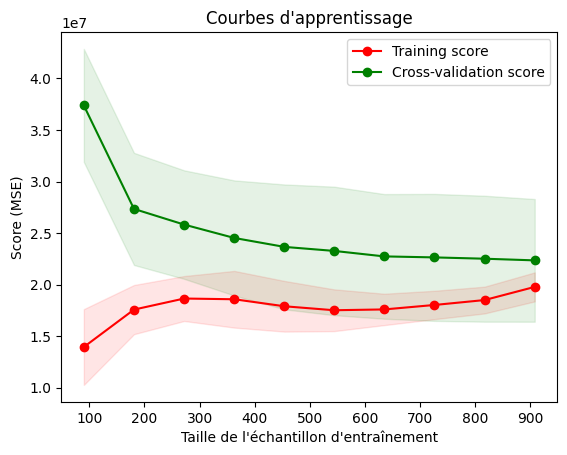

In [22]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Définir les intervalles pour la taille de l'échantillon d'entraînement
train_sizes = np.linspace(0.1, 1.0, 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

# Calculer les courbes d'apprentissage
train_sizes, train_scores, validation_scores = learning_curve(
    best_model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='neg_mean_squared_error'
)

# Calculer la moyenne et l'écart-type des scores d'entraînement et de validation
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
validation_scores_std = validation_scores.std(axis=1)

# Tracer les courbes d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Courbes d'apprentissage")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Score (MSE)")
plt.legend(loc="best")
plt.show()
